# Syntax Parsing and Statistical Machine Translation

In this session we will see how to use NLTK for PCFGs and Statistical Machine Translation

## 1. Constituent-based syntactic parsing

First of all, we will need to import nltk as usual and the nltk corpus of parsed WSJ treebank. This is a small portion of the WSJ treebank, but it will be enough for our purposes.

In [1]:
import nltk
from nltk.corpus import treebank

print(treebank.parsed_sents('wsj_0001.mrg')[0])

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


You can also use the **draw()** method to obtain a graphical representation of the parse tree:

In [2]:
treebank.parsed_sents('wsj_0001.mrg')[0].draw()

This method is part of the Tree NLTK class and has methods to read parse trees in bracketed format:

In [3]:
from nltk import Tree

s = '(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))'
t = Tree.fromstring(s)
print(t)


(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))


Let's see some other useful methods for the **Tree** class:

- Transforming the tree in Chomsky’s Normal Form:

In [4]:
t.chomsky_normal_form()

Obtaining the productions from a parse tree:

In [5]:
t.productions()

[S -> NP VP,
 NP -> DT NN,
 DT -> 'the',
 NN -> 'cat',
 VP -> VBD NP,
 VBD -> 'ate',
 NP -> DT NN,
 DT -> 'a',
 NN -> 'cookie']

For every production we can get the left and right parts of the productions:

In [6]:
for p in t.productions():
    print (p.lhs()) #left part (nonterminal)
    print (p.rhs()) #right part of the rule (sequence)

S
(NP, VP)
NP
(DT, NN)
DT
('the',)
NN
('cat',)
VP
(VBD, NP)
VBD
('ate',)
NP
(DT, NN)
DT
('a',)
NN
('cookie',)


### 1.1 Context-Free Grammars

NLTK includes several classes to encode CFG and PCFG grammars in the nltk.grammar module:

1.	Nonterminal
2.	Production (for rules)
3.	WeightedProduction (for rules in a PCFG)
4.	ContextFreeGrammar
5.	PCFG

The classes include convenient parsers to convert strings into grammars. The method *grammar.check_coverage(ws)* determines whether the words that appear in *ws* can ever be parsed by the grammar.

In [7]:
from nltk import nonterminals, Nonterminal, Production

# Create some nonterminals
S, NP, VP, PP, VB, NN = nonterminals('S, NP, VP, PP, VB, NN')
N, V, P, Det = nonterminals('N, V, P, Det')
# Create a production rule and print it
print(Production(S, [NP,VP]))


S -> NP VP


**Exercise 1**. Using the NLTK classes to encode elements of CFG grammars, estimate the probability of observing the rule 'NP -> NP PP' and the rule 'VP -> VB NP'

Remember that the probability for productions is estimated as:

$$p( X \to \alpha) =  \frac{c( X \to \alpha )}{c(X)}$$

In [8]:
#Suggestion: the following code helps browsing the treebank

productions=[]
for item in treebank.fileids():
    for tree in treebank.parsed_sents(item):
        tree.chomsky_normal_form() # Don’t forget to normalize in CNF the parse tree
        productions += tree.productions()

In [9]:
count_np_pp = sum(1 for p in productions if p.lhs() == NP and p.rhs() == (NP, PP))
count_vp_vb_np = sum(1 for p in productions if p.lhs() == VP and p.rhs() == (VB, NP))

prob_np_pp = count_np_pp / sum(1 for p in productions if p.lhs() == NP)
prob_vp_vb_np = count_vp_vb_np / sum(1 for p in productions if p.lhs() == VP)

print("Probability of observing the rule 'NP -> NP PP':", prob_np_pp)
print("Probability of observing the rule 'VP -> VB NP':", prob_vp_vb_np)

Probability of observing the rule 'NP -> NP PP': 0.09222728039116507
Probability of observing the rule 'VP -> VB NP': 0.055478980013783596


### 1.2 Moving to Probabilistic Context-Free Grammars

NLTK can do the work of inducing a PCFG from an existing Treebank. Once we have stored in productions all the productions from our treebank, we can obtain the PCFG as follows:

In [10]:
from nltk import Nonterminal

S = Nonterminal('S')
grammar = nltk.grammar.induce_pcfg(S, productions)

**Exercise 2**. Compare the values obtained in exercise 1 to those calculated automatically by the induce_pcfg method. (Hint: grammar.productions() to navigate through the productions of the grammar).

In [11]:
nonter = NP
seq = (NP, PP)

for p in grammar.productions():
    if p.lhs()== nonter:
        if p.rhs()== seq:
            print(p)

NP -> NP PP [0.0922273]


In [12]:
monter = VP
seq = (VB, NP)

boolen = False
for p in grammar.productions():
    if p.lhs()== nonter:
        if p.rhs() == seq:
            boolen = True
            print(p)
if boolen == False:
    print("No such rule")

No such rule


We get the same values for the rule 'NP -> NP PP' but for the rule 'VP -> VB NP', the induced model does not have any rule of this type.

### 1.3 Parsing

There are different types of parsers implemented in NLTK. One that implements the Viterbi CKY n-best parses over a PCFG is available in the *parse.viterbi* module:

In [13]:
for p in grammar.productions():
    if p.lhs()== NN:
        if p.rhs()[0].startswith("tel"):
            print(p)

NN -> 'television' [0.000683579]
NN -> 'telephone' [0.000759532]
NN -> 'telecommunications' [7.59532e-05]
NN -> 'telegraph' [7.59532e-05]
NN -> 'telephone-information' [7.59532e-05]


In [14]:
from nltk.parse import ViterbiParser

s='I saw John with my telephone'
tokens = s.split() #simplified – you can use a tokenizer
parser=ViterbiParser(grammar) #using the grammar induced by the Treebank
parses = parser.parse_all(tokens) #the resulting parse tree


**Exercise 3**. Test the above sentence and draw the resulting parse. Is this parse tree correct?
Verify if the sentence "I saw John with my telescope" is parsable.

In [15]:
parses[0].draw()

The phrase is ambiguous, but the parse tree is correct

In [16]:
s='I saw John with my telescope'
tokens = s.split() #simplified – you can use a tokenizer
parser=ViterbiParser(grammar) #using the grammar induced by the Treebank
try :
    parses = parser.parse_all(tokens) #the resulting parse tree
    parses[0].draw()
except ValueError:
    print("No parse tree found")

No parse tree found


## 2. Statistical Machine Translation

Objective: learn word alignments from a parallel corpus

NLTK includes an implementation of the IBM Model 1 in the package **nltk.align.ibm1** ; we will use this implementation to calculate a lexical translation dictionary.

First of all, we need to load the parallel corpus:

In [17]:
from nltk.corpus import comtrans

data = comtrans.aligned_sents("alignment-en-fr.txt") #this will load the alignments English-French

print(data[0])
print(len(data))

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>
33334


Now we can import the IBM Model 1 implementation and build the model (this will take some time):

In [18]:
from nltk import IBMModel1

#model=IBMModel1(data, 30) #data is the parallel corpus, 30 is the number of iterations for the EM algorithm

#to reduce the waiting time we can work on a smaller dataset:
model=IBMModel1(data[:10], 30) # or reduce the iterations for the EM algorithm

At this point we can look at the translation table to find the translation probabilities estimated by the IBM Model1:

In [19]:
print(model.translation_table["the"]["le"])
print(model.translation_table["the"]["la"])

1.3424467563162238e-05
0.13410723057727778


**Exercise 4**. Use a corpus of different sizes (10, 20, 30, 40 … 100) and max 30 iterations. Study the variation of the value of the probability of finding “le” given “the” (model.translation_table["the"]["le"]). Plot the result.


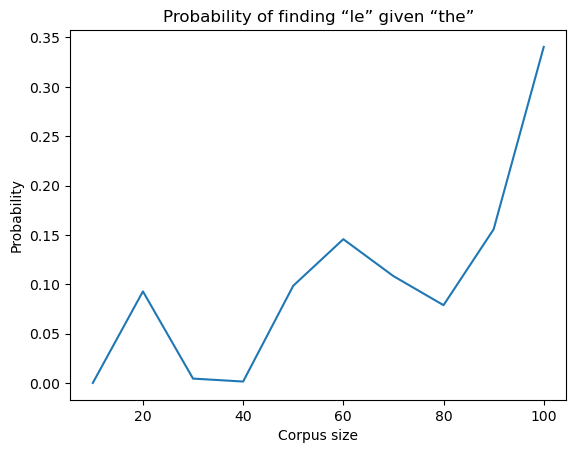

In [20]:
import matplotlib.pyplot as plt

x = []
y = []
for i in range(10, 101, 10):
    model=IBMModel1(data[:i], 30)
    x.append(i)
    y.append(model.translation_table["the"]["le"])

plt.plot(x, y)
plt.xlabel('Corpus size')
plt.ylabel('Probability')
plt.title('Probability of finding “le” given “the”')
plt.show()

**Exercise 5**. Try with a model of fixed size (100) while varying the number of iterations between 30 and 100 (step 10) and plot the result. Then try with a model of fixed size (50). Compare the behaviour of the models.

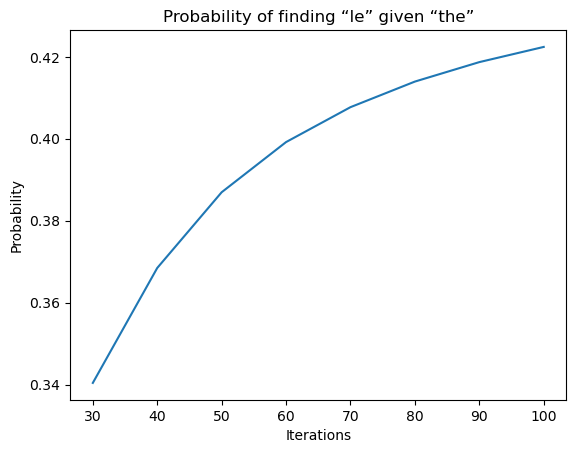

In [21]:
x = []
y = []

for i in range(30, 101, 10):
    model=IBMModel1(data[:100], i)
    x.append(i)
    y.append(model.translation_table["the"]["le"])

plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.title('Probability of finding “le” given “the”')
plt.show()

**Exercise 6**. Take the model built using 100 pairs of sentences and look at the values for [“dog”][“chien”] and ["is"]["est"]. What can you deduce about the underlying model?

In [22]:
model=IBMModel1(data[:100], 30)
print(model.translation_table["dog"]["chien"])
print(model.translation_table["is"]["est"])

1e-12
0.7337816125473016


<b>Exercise 7.</b> (optional) Take a look at the multi-head alignments obtained for an en-fr NMT model below. Consider the encoder attention alone, decoder attention alone and the cross-attention.
Test the result for the first 2 sentences in the file ```alignment-en-fr.txt``` : can you identify the role of some of the most important heads? Can you tell how many heads are actually contributing to the MT task?

In [25]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view

utils.logging.set_verbosity_error()  # Remove line to see warnings

# Initialize tokenizer and model. Be sure to set output_attentions=True.
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
model = AutoModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en", output_attentions=True)

# get encoded input vectors
encoder_input_ids = tokenizer("She sees the small elephant.", return_tensors="pt", add_special_tokens=True).input_ids

# create ids of encoded input vectors
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("Elle voit le petit éléphant.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens=decoder_text
)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

c:\Users\HP\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-fr-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

c:\Users\HP\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

c:\Users\HP\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
c:\Users\HP\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


<IPython.core.display.Javascript object>